<a href="https://colab.research.google.com/github/kchodkiewicz/deep-metric-learning-triplet-selection/blob/master/code/deep-metric-learning/notebooks/dml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-colab pandas tensorflow_datasets tensorflow keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_base_dir = './drive/MyDrive/studia/Magisterka'
data_base_dir = f'{drive_base_dir}/data'

ModuleNotFoundError: No module named 'google.colab'

**Hyper parameters**

In [ ]:
MARGIN = 2
BATCH_SIZE = 64

**Load data**

Pickle dump of dict, where:

```
data = {
  class1: [img_1_of_class_1, img_2_of_class_1, ... img_M_of_class_1],
  class2: [img_1_of_class_2, img_2_of_class_2, ... img_M_of_class_2],
  ...
  classN: [img_1_of_class_N, img_2_of_class_N, ... img_M_of_class_N],
}
```

and `N = number of classes`, `M = number of elements in class`.

Images should be passed in grayscale with dimentions 105x105 px.

In [3]:
import pandas as pd
import pickle
import tensorflow_datasets as tfds

omniglot_base_dir = f'{data_base_dir}/omniglot'

with open(f'{omniglot_base_dir}/omniglot_train_dict.pkl', 'rb') as f:
  train_data = pickle.load(f)

with open(f'{omniglot_base_dir}/omniglot_val_dict.pkl', 'rb') as f:
  val_data = pickle.load(f)


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_triplet(images, labels=('anchor', 'positive', 'negative'), ncols=3, cmap='gray'):
    '''Plot a grid of images'''
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1

    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]

    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)
            ax.grid(False)
            ax.axis("off")
            ax.set_title(labels[i])
    fig.show()


In [5]:
#@title Show whole dataset (unstable)
# printable_data = []
# # for val in train_data.
# # for key in train_data.keys():
# for num in range(len(train_data[0])):
#   for row in zip(*[train_data[key][num] for key in train_data.keys()]):
#     for item in row:
#       printable_data.append(item)

# plot_image_grid(printable_data, ncols=len(train_data.keys()))

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Flatten, Input

embeddings_size = 32

network = Sequential([
            Lambda(lambda image: tf.cast(image, tf.float32) / 255., input_shape=(105, 105, 1)),
            Conv2D(filters=16, kernel_size=(2, 2), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(4, 4)),
            Conv2D(filters=16, kernel_size=(2, 2), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(4, 4)),
            Conv2D(filters=embeddings_size, kernel_size=(2, 2), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(4, 4)),
            Flatten()
], name='Metric_Network')
network.summary()

Model: "Metric_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 105, 105, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 105, 105, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        1040      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 32)       

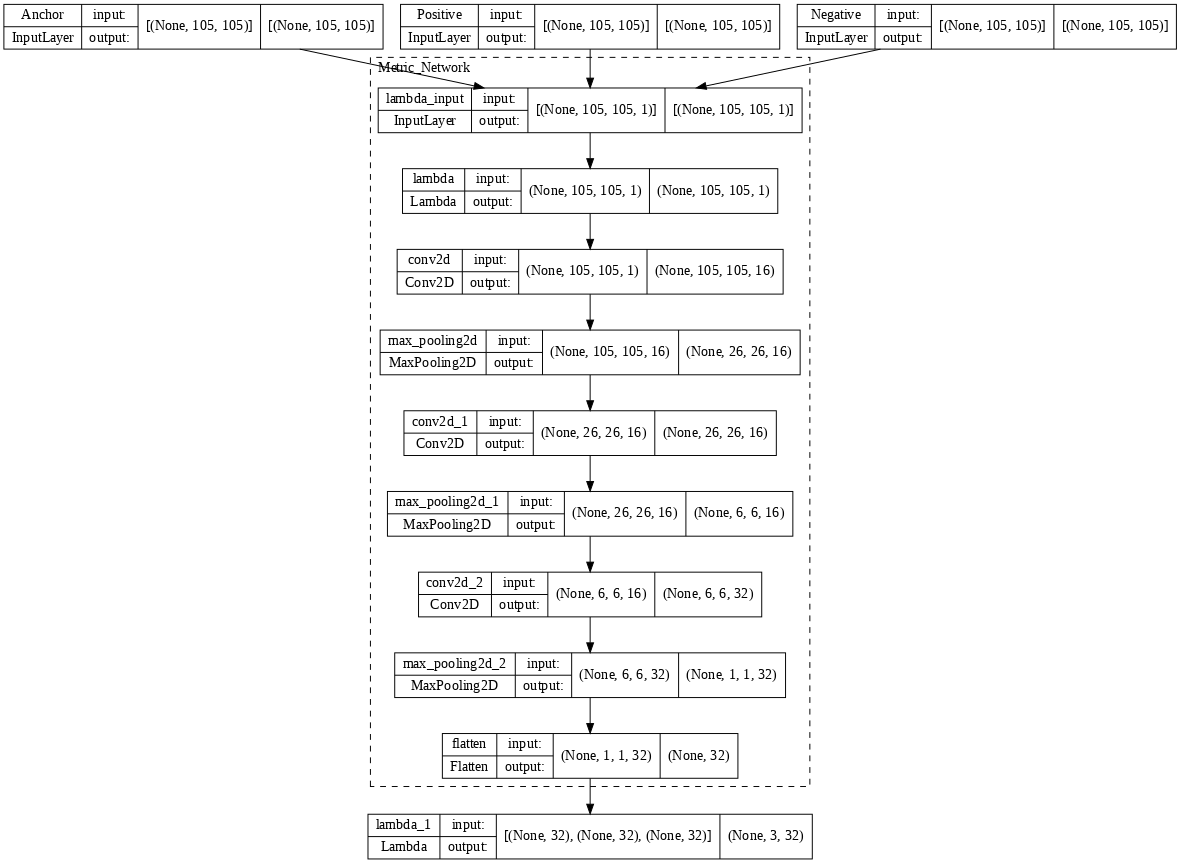

In [7]:
from tensorboard.notebook import display
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

a_input = Input(shape=(105, 105), name='Anchor')
p_input = Input(shape=(105, 105), name='Positive')
n_input = Input(shape=(105, 105), name='Negative')

a_embedding = network(a_input)
p_embedding = network(p_input)
n_embedding = network(n_input)

output = Lambda(
    lambda x: K.stack(x, axis=1))([
    a_embedding,
    p_embedding,
    n_embedding
])

model = Model(inputs=[a_input, p_input, n_input], outputs=[output])
display(plot_model(model, dpi=70, show_shapes=True, expand_nested=True))

**Triplet Selection**

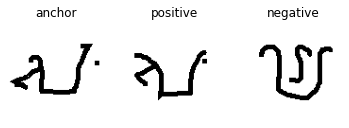

In [10]:
def get_random_triplet(data):
    p_class, n_class = np.random.randint(0, len(data.keys()), size=(2,))
    a_idx, p_idx = np.random.choice([idx for idx, _ in enumerate(data[p_class])], replace=False, size=(2,))
    a, p = data[p_class][a_idx], data[p_class][p_idx]
    n_idx = np.random.choice([idx for idx, _ in enumerate(data[n_class])])
    n = data[n_class][n_idx]
    return a, p, n

plot_triplet(get_random_triplet(train_data), ['anchor', 'positive', 'negative'], ncols=3)

**Triplet Loss**

In [11]:
from tensorflow.keras import backend as K

def triplet_loss(_, y_pred, margin=MARGIN):
    f_a, f_p, f_n = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
    dist_a_p = K.sum(K.square(f_a - f_p), axis=1)
    dist_a_n = K.sum(K.square(f_a - f_n), axis=1)

    loss = K.sum(K.relu(dist_a_p - dist_a_n + margin))
    return loss

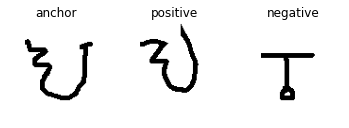

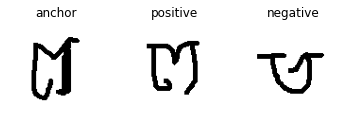

In [12]:
def gen_batch(data, batch_size=BATCH_SIZE):
    batch = np.zeros(shape=(batch_size, 3, 105, 105), dtype=np.uint8)
    y = np.zeros(shape=(batch_size, ))
    while True:
        for i in range(batch_size):
            A, P, N = get_random_triplet(train_data)
            batch[i, 0, :, :] = A
            batch[i, 1, :, :] = P
            batch[i, 2, :, :] = N
        yield (batch[:, 0, :, :], batch[:, 1, :, :], batch[:, 2, :, :]), y

batch, y = next(gen_batch(train_data, batch_size=2))
first_triplet = batch[0][0], batch[1][0], batch[2][0]
second_triplet = batch[0][1], batch[1][1], batch[2][1]

plot_triplet(first_triplet)
plot_triplet(second_triplet)

In [14]:
model.compile(loss=triplet_loss)
model.fit(gen_batch(train_data), steps_per_epoch=500, epochs=50)

Epoch 1/5
5000/5000 [==============================] - 168s 33ms/step - loss: 25.2495
Epoch 2/5
5000/5000 [==============================] - 197s 39ms/step - loss: 10.9709
Epoch 3/5
5000/5000 [==============================] - 175s 35ms/step - loss: 9.4860
Epoch 4/5
5000/5000 [==============================] - 154s 31ms/step - loss: 8.9732
Epoch 5/5
5000/5000 [==============================] - 148s 30ms/step - loss: 8.4911


**Predict**

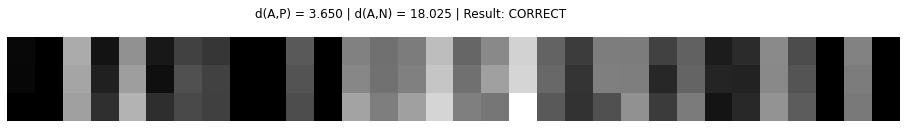

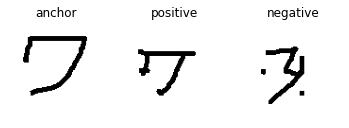

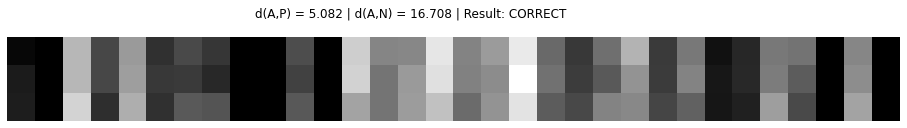

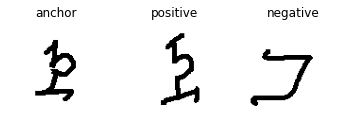

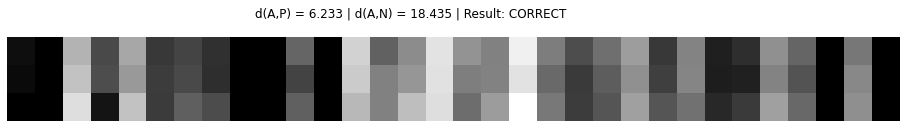

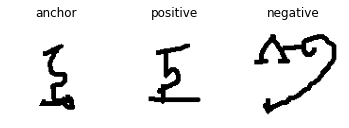

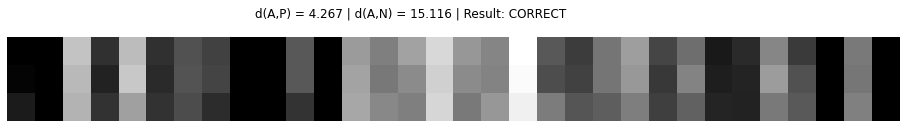

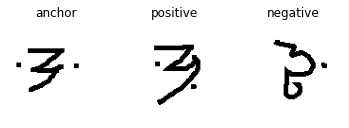

In [21]:
batch, _ = next(gen_batch(train_data, batch_size=4))
predictions = model.predict(batch)

for triplet in range(predictions.shape[0]):
    a_emb, p_emb, n_emb = predictions[triplet]
    plt.matshow(predictions[triplet], cmap='gray')

    dist_a_p = np.sum(np.square(a_emb - p_emb))
    dist_a_n = np.sum(np.square(a_emb - n_emb))

    plt.suptitle(f"d(A,P) = {dist_a_p:.3f} | d(A,N) = {dist_a_n:.3f} | Result: {'CORRECT' if dist_a_p < dist_a_n else 'WRONG'}")
    plt.axis('off')

    plot_triplet((batch[0][triplet], batch[1][triplet], batch[2][triplet]))
    plt.show()

In [23]:
def get_images_from_dict(data_dict):
    out = np.zeros(shape=(105, 105), dtype=np.uint8)
    for _, values_from_class in data_dict.items():
        for value in values_from_class:
            out.conjugate(value)
    return np.array(out)

    # np.array([(value for value in values_from_class) for _, values_from_class in data_dict.items()]).flatten('F')

In [24]:
from sklearn.metrics.pairwise import euclidean_distances

def compute_similarities(metric_network, imgs):
    # img_embs = []
    # for img in imgs:
    img_embs = metric_network.predict(imgs)
    similarities = euclidean_distances(img_embs)
    return similarities

test_list = get_images_from_dict(val_data)
print(test_list)
similarities = compute_similarities(network, test_list)

ValueError: ignored